## GPs using different libraries

The GP regression can be done using a few simple linear algebra operations. The big challenges/costs come up in the computation/storage of the covariance matrix and inversion operations. Here we use a few different libraries to show how GP regression can be done quite easily. 

Here we compare 4 options:
- Using native numpy/scipy
- Using JAX
- Using GPy
- Using GPytorch

In [3]:
import numpy as np
import GPy

from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

First we build a sample data set. 
This is what we will try to fit. 

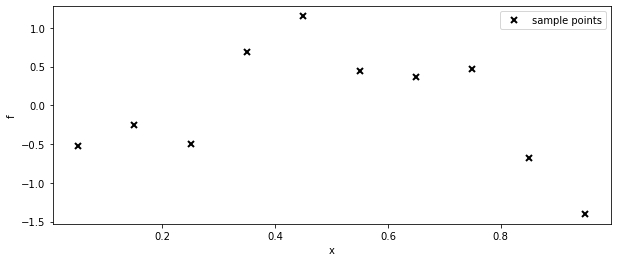

In [8]:
# Build data 

# lambda function, call f(x) to generate data
f = lambda x: -np.cos(2*np.pi*x) + 0.5*np.sin(6*np.pi*x)

# 10 equally spaced sample locations 
Xsamp = np.linspace(0.05, 0.95, 10)[:,None]

# y = f(X) + epsilon
Y = f(Xsamp) + np.random.normal(0., 0.1, (10,1)) # note that np.random.normal takes mean and s.d. (not variance), 0.1^2 = 0.01

# Setup our figure environment
plt.figure(figsize=(10, 4))

# Plot observations
plt.plot(Xsamp, Y, "kx", mew=2)

# Annotate plot
plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["sample points"]);

# How do GPs work? 

GPs essentially are a function estimator. We start by using a Gaussian prior, and then estimate a posterior, conditioned on the data points we have. 

This means that we start as: 
$$
f = N (m, C)
$$
Here f is a function, and we are saying that this function at any point can take values sampled from a normal distribution with mean m and covariance C. The normal distribution is infinite dimensional. The PDF can be written out as as well, which is an exponential function with a quadratic in it. 

But f is not what we want, since we don't want to know the function at an infinity of points and it is also not aware about our data. Instead what we want is 

$$
f^* | X^*, X, y = N (m^*, C^*),
$$

which is the function conditioned on the points we want to know its values ($X^*$), and the observation values $y$ at points $X$.

The nice things about Gaussians is that their conditional distributions are also known explicitly, so we know

$$
m^* =  \mathbf{K}_{*x}(\mathbf{K}_{xx} + \sigma^2\mathbf{I})^{-1}\mathbf{y}
$$

and 
$$
\mathbf{C}^* = \mathbf{K}_{**} -  \mathbf{K}_{*x}(\mathbf{K}_{xx} + \sigma^2\mathbf{I})^{-1}\mathbf{K}_{*x}^\text{T}
$$ 

and covariance matrices are defined by evaluations of the kernel functions: $\mathbf{K}_{xx} = k(\mathbf{X}, \mathbf{X})$; $\mathbf{K}_{*x} = k(\mathbf{X}^*, \mathbf{X})$; and $\mathbf{K}_{**} = k(\mathbf{X}^*,\mathbf{X}^*)$.



--- 
We can use this new conditioned distribution to know the mean of the unknown function, or generate samples to know particular realizations of the function. 

---

So, what remains to be done then? 

We need to know a few more things:
- We need to have a way to decide what kernel functions to use. 
- We need a way to estimate the hyperparameters for this kernel.

The choice of these things is essentially the same as saying that we are "choosing our model". 



The choice of kernel is something that will come from domain expertise + trial and error. 

Additionally models can be compared and hyperparameters tuned using maximum likelihood estimation. 

What is maximum likelihood estimation (MLE)?  
This process maximimizes the marginal likelihood. The reason this is done ie because we are trying to do something like 

$$ 
p(\theta| y) \propto p(y | \theta) p (\theta)
$$

We want to to maximize the LHS, but one way to do this is by maximizing the first term on the RHS (since the second term is something we will choose). 

### The (almost) raw method

In [7]:
# Build Kernel function 
# Using GPy here, but could technically have written out my own function. 
k = GPy.kern.RBF(1, variance=1., lengthscale=0.1, name="rbf")
k

rbf.,value,constraints,priors
variance,1.0,+ve,
lengthscale,0.1,+ve,


In [12]:
# The points we want to know answer at
Xtest =  np.linspace(0.05, 1.25, 50)[:,None] 

Ktt = k.K(Xtest,Xtest)
mean = 0 * Xtest

In [17]:
# If we only know Ktt and the mean, then we know the prior. We can sample from this. 
Zprior = np.random.multivariate_normal(mean[:,0], Ktt, 5)

Text(0.5, 1.0, 'Samples of possible prior functions')

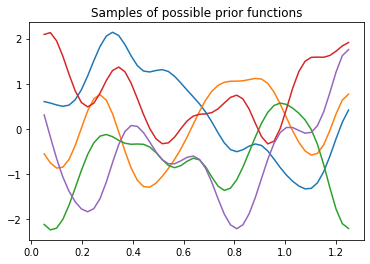

In [23]:
plt.plot(Xtest, Zprior.T);
plt.title('Samples of possible prior functions')

In [44]:
# Now if we have some data, we can estimate the conditioned distributions of the posterior

Kts = k.K(Xtest, Xsamp)
Kss = k.K(Xsamp, Xsamp)

mean_post = Kts @ np.linalg.inv(Kss + 0.1*np.eye(10)) @ Y

Cov_post = Ktt - Kts @ np.linalg.inv(Kss + 0.1*np.eye(10)) @ Kts.T

In [45]:
mean_post.shape

(50, 1)

In [48]:
Zpost = np.random.multivariate_normal(mean_post[:,0], Cov_post, 25)

Text(0.5, 1.0, 'Samples of possible posterior functions')

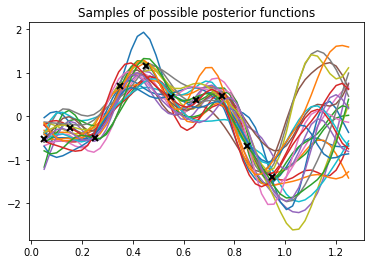

In [49]:
plt.plot(Xtest, Zpost.T);
plt.plot(Xsamp, Y, "kx", mew=2)
plt.title('Samples of possible posterior functions')

# These don't all pass through the sample points because we have not tuned our
# hyper parameters. 

In [ ]:
# We can compute the marginal likelihood and then maximize that wrt to the hyperparameters.

# didn't implement this yet. 

### Using GPy's inbuilt models 

In [50]:
m = GPy.models.GPRegression(Xsamp, Y, k)
m 

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,0.1,+ve,
Gaussian_noise.variance,1.0,+ve,


In [53]:
def plot_gp(X, m, C, training_points=None):
    """ Plotting utility to plot a GP fit with 95% confidence interval """
    # Plot 95% confidence interval 
    plt.fill_between(X[:,0],
                     m[:,0] - 1.96*np.sqrt(np.diag(C)),
                     m[:,0] + 1.96*np.sqrt(np.diag(C)),
                     alpha=0.5)
    # Plot GP mean and initial training points
    plt.plot(X, m, "-")
    plt.legend(labels=["GP fit"])
    
    plt.xlabel("x"), plt.ylabel("f")
    
    # Plot training points if included
    if training_points is not None:
        X_, Y_ = training_points
        plt.plot(X_, Y_, "kx", mew=2)
        plt.legend(labels=["GP fit", "sample points"])

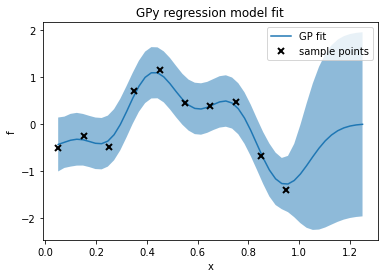

In [58]:
m.Gaussian_noise = 0.1

# Use GPy model to calculate the mean and covariance of the fit at Xnew
mean, Cov = m.predict_noiseless(Xtest, full_cov=True)


# Plot the GP fit mean and covariance
plot_gp(Xtest, mean, Cov, training_points=(X,Y))
plt.title("GPy regression model fit");

In [65]:
# easy one step optimization 
print(m)
m.Gaussian_noise.variance.unfix()

m.optimize()
m


Name : GP regression
Objective : 8.535336109531075
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |   0.6141263949370515  |      +ve      |        
  rbf.lengthscale          |  0.10670530614685712  |      +ve      |        
  Gaussian_noise.variance  |                 0.01  |   +ve fixed   |        


GP_regression.,value,constraints,priors
rbf.variance,0.6243317308698012,+ve,
rbf.lengthscale,0.10466796164180157,+ve,
Gaussian_noise.variance,9.057479867184146e-08,+ve,


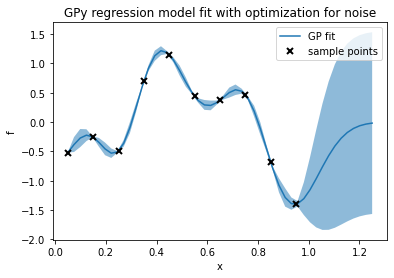

In [66]:
# Use GPy model to calculate the mean and covariance of the fit at Xnew
mean, Cov = m.predict_noiseless(Xtest, full_cov=True)


# Plot the GP fit mean and covariance
plot_gp(Xtest, mean, Cov, training_points=(X,Y))
plt.title("GPy regression model fit with optimization for noise");

Since the GP model has a lot of freedome with the RBF kernel, it maximizes the likelhood by passing the mean through the samples and reducing variance there to 0. To get around this, we fix noise. 

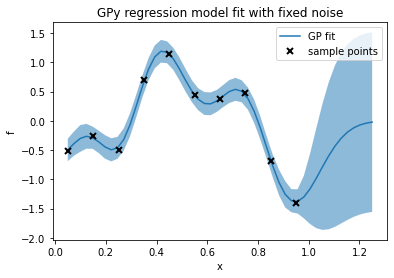

In [67]:
# Fix the Gaussian noise variance at 0.01 
m.Gaussian_noise.variance = 0.01 # (Reset the parameter first)
m.Gaussian_noise.variance.fix()

# Reoptimise
m.optimize()
m

# Use GPy model to calculate the mean and covariance of the fit at Xnew
mean, Cov = m.predict_noiseless(Xtest, full_cov=True)


# Plot the GP fit mean and covariance
plot_gp(Xtest, mean, Cov, training_points=(X,Y))
plt.title("GPy regression model fit with fixed noise");

### Using GPytorch 
Does not have inbuilt models, but provides all components to build our own. 

According to their website they divide the process of GP regression into 5 components: 

a) GP Model (`gpytorch.models.ExactGP`) - this handles most of the inference. Where inference means to make a prediction based on the model.

b) Likelihood (`gpytorch.likelihoods.GaussianLikelihood`) - this defines the mapping from the latent function values $f(\mathbf{X})$ to observations $y$. Basically the noise model. The forward function for this returns $p(y | f(X))$. 

c) Mean (`gpytorch.means.ConstantMean()`) - defines the mean for the prior. 

d) Kernel (`gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())`)

e) MultivariateNormal (`gpytorch.distributions.MultivariateNormal`) - used to represent multivariate normals (sort of what a GP is). 


In [97]:
import gpytorch
import torch
import math

In [136]:
train_x = torch.from_numpy(Xsamp[:,0])
train_y = torch.from_numpy(Y[:,0])

In [152]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [153]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

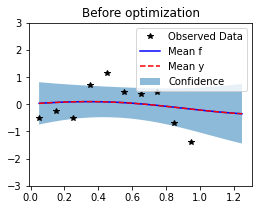

In [154]:
# set eval mode
model.eval()
likelihood.eval()

# find the distributions corresponding to f and y
f_preds = model(test_x)
y_preds = likelihood(model(test_x))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = f_preds.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), f_preds.mean.numpy(), 'b')
    ax.plot(test_x.numpy(), y_preds.mean.numpy(), 'r--')    
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean f', 'Mean y', 'Confidence'])
    
    plt.title('Before optimization')

In [155]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

training_iter = 30

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/30 - Loss: 1.251   lengthscale: 0.693   noise: 0.693
Iter 2/30 - Loss: 1.233   lengthscale: 0.644   noise: 0.644
Iter 3/30 - Loss: 1.215   lengthscale: 0.599   noise: 0.598
Iter 4/30 - Loss: 1.196   lengthscale: 0.557   noise: 0.555
Iter 5/30 - Loss: 1.178   lengthscale: 0.517   noise: 0.514
Iter 6/30 - Loss: 1.160   lengthscale: 0.479   noise: 0.476
Iter 7/30 - Loss: 1.141   lengthscale: 0.443   noise: 0.439
Iter 8/30 - Loss: 1.119   lengthscale: 0.409   noise: 0.405
Iter 9/30 - Loss: 1.093   lengthscale: 0.377   noise: 0.373
Iter 10/30 - Loss: 1.065   lengthscale: 0.346   noise: 0.343
Iter 11/30 - Loss: 1.036   lengthscale: 0.317   noise: 0.314
Iter 12/30 - Loss: 1.008   lengthscale: 0.290   noise: 0.287
Iter 13/30 - Loss: 0.985   lengthscale: 0.265   noise: 0.262
Iter 14/30 - Loss: 0.969   lengthscale: 0.243   noise: 0.239
Iter 15/30 - Loss: 0.961   lengthscale: 0.224   noise: 0.218
Iter 16/30 - Loss: 0.957   lengthscale: 0.207   noise: 0.199
Iter 17/30 - Loss: 0.955   length

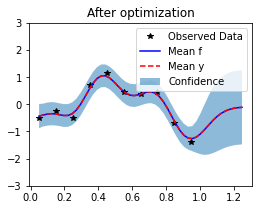

In [156]:
# set eval mode
model.eval()
likelihood.eval()

# find the distributions corresponding to f and y
f_preds = model(test_x)
y_preds = likelihood(model(test_x))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = f_preds.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), f_preds.mean.numpy(), 'b')
    ax.plot(test_x.numpy(), y_preds.mean.numpy(), 'r--')    
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean f', 'Mean y','Confidence'])
    
    plt.title('After optimization')

### Using JAX 

... 

JAX is a new library that has built in automatic gradient, and is similar to numpy. Junming has code that does GPs in JAX. 